In [ ]:
import os
import re
import torch
import datetime
import kss
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, udf
from pyspark.sql.types import StringType, ArrayType
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ MySQL 연결 정보
MYSQL_JAR_PATH = "/usr/local/lib/mysql-connector-j-8.0.33.jar"
DB_HOST = "15.152.242.221"
DB_PORT = 3306
DB_USER = "admin"
DB_PASSWORD = "Admin@1234"
DB_NAME = "musinsa_pd_rv"
DB_TABLE = "reviews"

DB_URL = f"jdbc:mysql://{DB_HOST}:{DB_PORT}/{DB_NAME}?useSSL=false&allowPublicKeyRetrieval=true"
DB_PROPERTIES = {"user": DB_USER, "password": DB_PASSWORD, "driver": "com.mysql.cj.jdbc.Driver"}

# ✅ SparkSession 생성 (실행자 수 1개로 제한, 메모리 최적화)
spark = SparkSession.builder \
    .appName("SentimentCategoryAnalysis") \
    .config("spark.jars", MYSQL_JAR_PATH) \
    .config("spark.driver.extraClassPath", MYSQL_JAR_PATH) \
    .config("spark.executor.extraClassPath", MYSQL_JAR_PATH) \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

print("[INFO] ✅ SparkSession 생성 완료")

# ✅ MySQL에서 데이터 로드
print("[INFO] 🔄 MySQL에서 데이터 로드 중...")
df_reviews = spark.read.format("jdbc") \
    .option("url", DB_URL) \
    .option("dbtable", DB_TABLE) \
    .option("user", DB_PROPERTIES["user"]) \
    .option("password", DB_PROPERTIES["password"]) \
    .option("driver", DB_PROPERTIES["driver"]) \
    .option("fetchsize", "5000") \
    .load()
print("[INFO] ✅ 데이터 로드 완료")

# ✅ 필요한 컬럼 선택
df_reviews = df_reviews.select("review_id", "product_id", "review_text", "rating", "review_date", "review_size")

# ✅ 텍스트 전처리 함수 (불용어 제거 포함)
stopwords = set([
    "아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게",
    "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고",
    "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고",
    "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다",
    "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에",
    "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여",
    "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시",
    "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서",
    "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마",
    "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면",
    "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당",
    "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로",
    "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다",
    "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳",
    "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차",
    "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면",
    "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도",
    "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼", "어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아",
    "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서",
    "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고",
    "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", 
    '너무', '더보기', '히히', '크크', '케케', '그냥', '잉', '앙', '엉', '옹', '하', '야', '이야'
])

def clean_text(text):
    if not text or text.strip() == "":
        return ""
    text = re.sub(r"[ㅋㅎㅠㅜ]+", "", text)  # 감탄사 제거
    text = re.sub(r"[^가-힣\s]", "", text)  # 한글 및 공백만 유지
    words = text.split()
    words = [word for word in words if word not in stopwords]  # 불용어 제거
    return " ".join(words).strip()

def split_sentences(text):
    if not text or text.strip() == "":
        return []
    return kss.split_sentences(text)

# ✅ UDF 등록
clean_text_udf = udf(clean_text, StringType())
split_sentences_udf = udf(split_sentences, ArrayType(StringType()))

# ✅ 전처리 적용
print("[INFO] 🔄 리뷰 텍스트 전처리 중...")
df_reviews = df_reviews.withColumn("cleaned_text", clean_text_udf(col("review_text")))
df_reviews = df_reviews.withColumn("sentences", split_sentences_udf(col("cleaned_text")))
df_reviews = df_reviews.withColumn("sentence", explode(col("sentences"))).drop("sentences")
df_reviews = df_reviews.dropDuplicates(["review_id", "cleaned_text"]).persist()
print("[INFO] ✅ 리뷰 전처리 완료")

# ✅ 모델 로드 및 최적화
category_model_path = "/home/lab01/airflow/model/best_model.pth"
sentiment_model_path = "/home/lab01/airflow/model/best_model_with_val.pth"

# ✅ 카테고리 분류 모델 로드
print("[INFO] 🔄 카테고리 분류 모델 로드 중...")
category_model_data = torch.load(category_model_path, map_location=device)

if isinstance(category_model_data, dict):  # ✅ state_dict 형태
    category_model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=6)
    category_model.load_state_dict(category_model_data)
else:  # ✅ 전체 모델 객체
    category_model = category_model_data

category_model.to(device).eval()
print("[INFO] ✅ 카테고리 분류 모델 로드 완료")

# ✅ 감성 분석 모델 로드
print("[INFO] 🔄 감성 분석 모델 로드 중...")
sentiment_model_data = torch.load(sentiment_model_path, map_location=device)

if isinstance(sentiment_model_data, dict):  # ✅ state_dict 형태
    sentiment_model = AutoModelForSequenceClassification.from_pretrained(
        "monologg/kobert",
        num_labels=3,
        trust_remote_code=True
    )
    sentiment_model.load_state_dict(sentiment_model_data, strict=False)
else:  # ✅ 전체 모델 객체
    sentiment_model = sentiment_model_data

sentiment_model.to(device).eval()
print("[INFO] ✅ 감성 분석 모델 로드 완료")

from tqdm import tqdm
import sys

def process_reviews(partition, batch_size=64):
    CATEGORIES = ["가성비", "내구성 및 품질", "디자인", "배송 및 포장 및 응대", "사이즈", "착용감"]
    
    texts = []
    rows = []
    
    pbar = tqdm(desc="Processing Reviews", leave=True, file=sys.stdout, disable=False)  # 🔹 tqdm 출력 방식 변경
    
    for row in partition:
        text = row.sentence if hasattr(row, "sentence") else ""
        texts.append(text)
        rows.append(row)
        pbar.update(1)  # 🔹 진행률 업데이트

        if len(texts) >= batch_size:
            inputs = sentiment_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device, non_blocking=True)
            with torch.no_grad():
                sentiment_outputs = sentiment_model(**inputs)
                sentiment_preds = torch.argmax(sentiment_outputs.logits, dim=-1).cpu().tolist()

            inputs = category_tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device, non_blocking=True)
            with torch.no_grad():
                category_outputs = category_model(**inputs)
                category_preds = (torch.sigmoid(category_outputs.logits) > 0.5).int().cpu().tolist()

            for i, row in enumerate(rows):
                category_labels = [CATEGORIES[j] for j in range(len(CATEGORIES)) if category_preds[i][j] == 1]
                category_result = ",".join(category_labels) if category_labels else "기타"
                yield (row.review_id, row.product_id, texts[i], sentiment_preds[i], category_result, row.rating, row.review_date, row.review_size)
            
            texts = []
            rows = []

    pbar.close()  # 🔹 tqdm 종료


# ✅ 감성 분석 및 카테고리 분류 적용
df_rdd = df_reviews.repartition(4).rdd.mapPartitions(lambda partition: process_reviews(partition, batch_size=64))
df_final = spark.createDataFrame(df_rdd, schema=["review_id", "product_id", "sentence", "sentiment", "category", "rating", "review_date", "review_size"])
print("[INFO] ✅ 감성 분석 및 카테고리 분류 완료")

# ✅ 로컬 저장 경로 설정
local_output_path = "/home/lab01/mysql/reviews_parquet"

# ✅ 기존 데이터 삭제 (기존 파일이 있으면 삭제 후 저장)
import shutil
import os

if os.path.exists(local_output_path):
    print(f"[INFO] 🔄 기존 로컬 Parquet 데이터 삭제 중: {local_output_path}")
    shutil.rmtree(local_output_path)

# ✅ Parquet 형식으로 저장
print(f"[INFO] 🔄 Parquet 파일 저장 중: {local_output_path}")
df_final.write.mode("overwrite").parquet(local_output_path)
print(f"[INFO] ✅ Parquet 저장 완료: {local_output_path}")

df_final.show(10)


/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-03 02:54:01,787 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[INFO] ✅ SparkSession 생성 완료
[INFO] 🔄 MySQL에서 데이터 로드 중...
[INFO] ✅ 데이터 로드 완료
[INFO] 🔄 리뷰 텍스트 전처리 중...
[INFO] ✅ 리뷰 전처리 완료
[INFO] 🔄 카테고리 분류 모델 로드 중...
[INFO] ✅ 카테고리 분류 모델 로드 완료
[INFO] 🔄 감성 분석 모델 로드 중...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] ✅ 감성 분석 모델 로드 완료


[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D

[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D

[Stage 0:>                                                          (0 + 1) / 1]

In [1]:
import os
import re
import torch
import kss
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] ✅ GPU 사용 여부: {device}")

# ✅ MySQL 연결 정보
MYSQL_JAR_PATH = "/usr/local/lib/mysql-connector-j-8.0.33.jar"
DB_HOST = "15.152.242.221"
DB_PORT = 3306
DB_USER = "admin"
DB_PASSWORD = "Admin@1234"
DB_NAME = "musinsa_pd_rv"
DB_TABLE = "reviews"

DB_URL = f"jdbc:mysql://{DB_HOST}:{DB_PORT}/{DB_NAME}?useSSL=false&allowPublicKeyRetrieval=true"
DB_PROPERTIES = {"user": DB_USER, "password": DB_PASSWORD, "driver": "com.mysql.cj.jdbc.Driver"}

# ✅ SparkSession 생성 (최적화)
spark = SparkSession.builder \
    .appName("SentimentCategoryAnalysis") \
    .config("spark.jars", MYSQL_JAR_PATH) \
    .config("spark.driver.extraClassPath", MYSQL_JAR_PATH) \
    .config("spark.executor.extraClassPath", MYSQL_JAR_PATH) \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

print("[INFO] ✅ SparkSession 생성 완료")

# ✅ MySQL에서 데이터 로드
print("[INFO] 🔄 MySQL에서 데이터 로드 중...")
df_reviews = spark.read.format("jdbc") \
    .option("url", DB_URL) \
    .option("dbtable", DB_TABLE) \
    .option("user", DB_PROPERTIES["user"]) \
    .option("password", DB_PROPERTIES["password"]) \
    .option("driver", DB_PROPERTIES["driver"]) \
    .option("fetchsize", "5000") \
    .load()
df_reviews.cache()  # ✅ Spark 캐시 적용하여 속도 향상
print("[INFO] ✅ 데이터 로드 완료")

# ✅ 데이터 개수 확인 (최적화)
review_count = df_reviews.count()
print(f"[INFO] 🔢 데이터 개수: {review_count}")

# ✅ 필요한 컬럼 선택
df_reviews = df_reviews.select("review_id", "product_id", "review_text", "rating", "review_date", "review_size")
df_reviews.show(5, truncate=False)  # ✅ 샘플 데이터 출력


/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] ✅ GPU 사용 여부: cuda


2025-03-03 03:35:13,851 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[INFO] ✅ SparkSession 생성 완료
[INFO] 🔄 MySQL에서 데이터 로드 중...
[INFO] ✅ 데이터 로드 완료


[INFO] 🔢 데이터 개수: 559147
+---------+----------+---------------------------------------------------------------------------------------------------+------+-----------+---------------+
|review_id|product_id|review_text                                                                                        |rating|review_date|review_size    |
+---------+----------+---------------------------------------------------------------------------------------------------+------+-----------+---------------+
|10000086 |1417451   |270~275인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 너무 좋구요 블랙슬렉스에 이쁠거 같아요 |5.0   |2020-06-03 |42 (275mm) 구매|
|10000110 |1092992   |너무 편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 다만 재질상 땀이 나면 어떨지 신어봐야겠네요~|5.0   |2020-06-03 |260 구매       |
|10000121 |1092992   |커플로 주문했습니다 급하게 나갈때는 이거만 신네요 ㅋㅋ                                             |5.0   |2020-06-03 |230 구매       |
|10000123 |1092992   |너무 푹신해서 다리가 조금 불편하기도 합니다요                                                      |4.0   |2020-06-03 |280 구매       |
|1000

In [3]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# 불용어 리스트 정의
stopwords = set([
    "아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게",
    "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고",
    "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고",
    "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다",
    "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에",
    "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여",
    "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시",
    "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서",
    "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마",
    "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면",
    "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당",
    "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로",
    "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다",
    "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳",
    "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차",
    "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면",
    "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도",
    "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼", "어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아",
    "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서",
    "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고",
    "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", 
    '너무', '더보기', '히히', '크크', '케케', '그냥', '잉', '앙', '엉', '옹', '하', '야', '이야'
])

# 텍스트 정제 함수
def clean_text(text):
    text = str(text)

    # ㅋㅋㅋ, ㅎㅎㅎ, ㅠㅠㅠ 같은 감탄사 제거
    text = re.sub(r"ㅋ{2,}|ㅎ{2,}|ㅠ{2,}|ㅜ{2,}", "", text)
    
    # 한글 및 공백만 남기고 제거
    text = re.sub(r"[^가-힣\s]", "", text)
    
    # 불용어 제거
    words = text.split()
    words = [word for word in words if word not in stopwords]
    
    # 정제된 단어들을 다시 합침
    text = " ".join(words)
    
    # 공백 정리
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

# UDF 등록
clean_text_udf = udf(clean_text, StringType())

# PySpark DataFrame에서 UDF 사용하여 텍스트 정제 적용
df_reviews = df_reviews.withColumn("cleaned_review", clean_text_udf(col("review_text")))

# 정제된 데이터 샘플 확인
df_reviews.select("review_text", "cleaned_review").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+
|review_text                                                                                        |cleaned_review                                                                          |
+---------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+
|270~275인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 너무 좋구요 블랙슬렉스에 이쁠거 같아요 |인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 좋구요 블랙슬렉스에 이쁠거 같아요  |
|너무 편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 다만 재질상 땀이 나면 어떨지 신어봐야겠네요~|편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 재질상 땀이 나면 어떨지 신어봐야겠네요|
|커플로 주문했습니다 급하게 나갈때는 이거만 신네요 ㅋㅋ                                             |커플로 주문했습니다 급하게 나갈때는 이거만 신네요                                       |
|너무 푹신해서 다리가 조금 불편하기도 합니다요                                  

In [7]:
df_reviews.show(10, truncate=False)

+---------+----------+---------------------------------------------------------------------------------------------------+------+-----------+---------------+----------------------------------------------------------------------------------------+
|review_id|product_id|review_text                                                                                        |rating|review_date|review_size    |cleaned_review                                                                          |
+---------+----------+---------------------------------------------------------------------------------------------------+------+-----------+---------------+----------------------------------------------------------------------------------------+
|10000086 |1417451   |270~275인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 너무 좋구요 블랙슬렉스에 이쁠거 같아요 |5.0   |2020-06-03 |42 (275mm) 구매|인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 좋구요 블랙슬렉스에 이쁠거 같아요  |
|10000110 |1092992   |너무 편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 다만 재질상 땀이 나면 어떨지 신어봐야겠네요~|5.0   |2020-0

In [12]:
# ✅ pandas로 변환하여 CSV 저장
import pandas as pd

csv_output_path = "/home/lab01/mysql/reviews.csv"  # 원하는 CSV 파일명

df_pandas = df_reviews.toPandas()  # PySpark DF → pandas DF 변환
df_pandas.to_csv(csv_output_path, index=False, encoding="utf-8-sig")

print(f"[INFO] ✅ CSV 저장 완료: {csv_output_path}")


[INFO] ✅ CSV 저장 완료: /home/lab01/mysql/reviews.csv


In [2]:
import pandas as pd

# CSV 파일 경로
csv_file_path = "/home/lab01/mysql/reviews.csv"

# CSV 파일 로드
df = pd.read_csv(csv_file_path, encoding="utf-8-sig")

# 데이터 확인
print(df.head())


   review_id  product_id                                        review_text  \
0   10000086     1417451  270~275인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 너무 좋구요 블랙...   
1   10000110     1092992  너무 편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 다만 재질상 땀이 나면 어떨...   
2   10000121     1092992                     커플로 주문했습니다 급하게 나갈때는 이거만 신네요 ㅋㅋ   
3   10000123     1092992                          너무 푹신해서 다리가 조금 불편하기도 합니다요   
4   10000139     1092992             발이너무 편해요 발등부분이 좀만더 타이트했으면 좋았겠어요~ 살짝헐렁임   

   rating review_date    review_size  \
0     5.0  2020-06-03  42 (275mm) 구매   
1     5.0  2020-06-03         260 구매   
2     5.0  2020-06-03         230 구매   
3     4.0  2020-06-03         280 구매   
4     5.0  2020-06-03         250 구매   

                                      cleaned_review  
0   인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 좋구요 블랙슬렉스에 이쁠거 같아요  
1  편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 재질상 땀이 나면 어떨지 신어봐야겠네요  
2                        커플로 주문했습니다 급하게 나갈때는 이거만 신네요  
3                                푹신해서 다리가 불편하기도 합니다요  
4        

In [3]:
# 데이터 개수 출력
print(f"데이터 개수: {len(df)}")


데이터 개수: 559147


In [ ]:
import os
import re
import pandas as pd
import torch
import torch.nn.functional as F
import kss
from tqdm import tqdm
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification
)

# ✅ CSV 파일 불러오기
csv_file_path = "/home/lab01/mysql/reviews.csv"
df = pd.read_csv(csv_file_path, encoding="utf-8-sig")
print(f"[INFO] 🔄 데이터 로드 완료 | 총 {len(df)}개")

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] ✅ GPU 사용 여부: {device}")

# ✅ 감성 분석 및 카테고리 분류 모델 로드
sentiment_model_path = "/home/lab01/airflow/model/best_model_with_val.pth"
category_model_path = "/home/lab01/airflow/model/best_model.pth"

try:
    # ✅ 카테고리 분류 모델 (`klue/bert-base`)
    print("[INFO] 카테고리 분류 모델 로드 중...")
    category_tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
    category_model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=6)

    # 모델 저장 방식 확인 후 로드
    category_model_data = torch.load(category_model_path, map_location=device)
    if isinstance(category_model_data, dict):
        category_model.load_state_dict(category_model_data, strict=False)  # 🔹 strict=False 옵션 추가
    else:
        category_model = category_model_data  # 전체 모델이 저장된 경우

    category_model.to(device).eval()
    print("[INFO] ✅ 카테고리 분류 모델 로드 완료")

    # ✅ 감성 분석 모델 (`monologg/kobert`)
    print("[INFO] 감성 분석 모델 로드 중...")
    sentiment_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)
    sentiment_model = AutoModelForSequenceClassification.from_pretrained(
        "monologg/kobert",
        num_labels=3,
        trust_remote_code=True  # 🔹 신뢰 코드 실행 옵션 추가
    )
    sentiment_model.load_state_dict(torch.load(sentiment_model_path, map_location=device), strict=False)
    sentiment_model.to(device).eval()
    print("[INFO] ✅ 감성 분석 모델 로드 완료")

except Exception as e:
    print(f"[ERROR] ❌ 모델 로드 실패: {e}")
    exit(1)

# ✅ 카테고리 목록
CATEGORIES = ["가성비", "내구성 및 품질", "디자인", "배송 및 포장 및 응대", "사이즈", "착용감"]
SENTIMENT_LABELS = {0: "부정", 1: "중립", 2: "긍정"}

# ✅ 텍스트 정제 함수
def clean_text(text):
    text = str(text)
    text = re.sub(r"ㅋ{2,}|ㅎ{2,}|ㅠ{2,}|ㅜ{2,}", "", text)  # 감탄사 제거
    text = re.sub(r"[^가-힣\s]", "", text)  # 한글 및 공백만 남기고 제거
    text = re.sub(r"\s+", " ", text).strip()  # 공백 정리
    return text

# ✅ 문장 분리 함수
def split_sentences(review):
    return kss.split_sentences(review)

# ✅ 카테고리 예측 함수
def predict_category(sentence):
    inputs = category_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = category_model(**inputs)

    probs = torch.sigmoid(outputs.logits)
    predictions = (probs > 0.5).int()

    predicted_labels = [CATEGORIES[j] for j in range(len(CATEGORIES)) if predictions[0][j] == 1]
    return predicted_labels if predicted_labels else ["기타"]

# ✅ 감성 분석 예측 함수
def predict_sentiment(sentence):
    inputs = sentiment_tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = sentiment_model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_class = torch.argmax(probs, dim=-1).item()  # 0: 부정, 1: 중립, 2: 긍정
    return sentiment_class

# ✅ 감성 분석 및 카테고리 분류 진행 함수
def analyze_review(text):
    text = clean_text(text)  # 텍스트 정제
    sentences = split_sentences(text)  # 문장 분리

    all_sentiments = []
    all_categories = []

    for sentence in sentences:
        sentiment = predict_sentiment(sentence)
        categories = predict_category(sentence)

        all_sentiments.append(SENTIMENT_LABELS[sentiment])
        all_categories.extend(categories)

    # 카테고리 중복 제거
    all_categories = list(set(all_categories))

    return ",".join(all_sentiments), ",".join(all_categories)

# ✅ 데이터프레임 전체 적용 (진행률 표시)
print("[INFO] 🔄 감성 분석 및 카테고리 분류 진행 중...")
tqdm.pandas()

df[["sentiment", "category"]] = df["cleaned_review"].progress_apply(lambda x: pd.Series(analyze_review(x)))

# ✅ MySQL `review_analysis` 테이블 스키마에 맞춘 데이터프레임 생성
df_final = df[["review_id", "product_id", "cleaned_review", "category", "sentiment", "rating", "review_date"]]
df_final.columns = ["review_id", "product_id", "sentence", "category", "sentiment", "rating", "review_date"]

# ✅ CSV로 저장
output_csv_path = "/home/lab01/mysql/reviews_labeled.csv"
df_final.to_csv(output_csv_path, encoding="utf-8-sig", index=False)

print(f"[INFO] ✅ 감성 분석 및 카테고리 분류 완료 | 저장 경로: {output_csv_path}")

# ✅ 데이터 개수 확인
print(df_final.head())
print(f"[INFO] 🔢 총 {len(df_final)}개 데이터 처리 완료")


[INFO] 🔄 데이터 로드 완료 | 총 559147개
[INFO] ✅ GPU 사용 여부: cuda
[INFO] 카테고리 분류 모델 로드 중...


/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClas

[INFO] ✅ 카테고리 분류 모델 로드 완료
[INFO] 감성 분석 모델 로드 중...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] ✅ 감성 분석 모델 로드 완료
[INFO] 🔄 감성 분석 및 카테고리 분류 진행 중...


[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D

  3%|▎         | 14867/559147 [10:52<6:36:04, 22.90it/s] 

In [9]:
print(type(category_model))  # 모델 타입 확인

<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [2]:
import os
import re
import pandas as pd
import torch
import torch.nn.functional as F
import kss
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification
)

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] ✅ GPU 사용 여부: {device}")

# ✅ 모델 및 토크나이저 로드
sentiment_model_path = "/home/lab01/airflow/model/best_model_with_val.pth"
category_model_path = "/home/lab01/airflow/model/best_model.pth"

print("[INFO] ✅ 모델 로드 중...")
category_tokenizer = BertTokenizer.from_pretrained("klue/bert-base")
category_model = BertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=6)

category_model_data = torch.load(category_model_path, map_location=device)
if isinstance(category_model_data, dict):
    category_model.load_state_dict(category_model_data, strict=False)
else:
    category_model = category_model_data

category_model.to(device).eval()

sentiment_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert", trust_remote_code=True)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(
    "monologg/kobert", num_labels=3, trust_remote_code=True
)
sentiment_model.load_state_dict(torch.load(sentiment_model_path, map_location=device), strict=False)
sentiment_model.to(device).eval()
print("[INFO] ✅ 모델 로드 완료")

# ✅ 카테고리 목록
CATEGORIES = ["가성비", "내구성 및 품질", "디자인", "배송 및 포장 및 응대", "사이즈", "착용감"]
SENTIMENT_LABELS = {0: "부정", 1: "중립", 2: "긍정"}

# ✅ 텍스트 정제 함수
def clean_text(text):
    text = str(text)
    text = re.sub(r"ㅋ{2,}|ㅎ{2,}|ㅠ{2,}|ㅜ{2,}", "", text)  # 감탄사 제거
    text = re.sub(r"[^가-힣\s]", "", text)  # 한글 및 공백만 남기고 제거
    text = re.sub(r"\s+", " ", text).strip()  # 공백 정리
    return text

# ✅ PyTorch Dataset 정의 (수정됨)
class ReviewDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = clean_text(row["cleaned_review"])
        return row["review_id"], row["product_id"], text, row["rating"], row["review_date"]

# ✅ Collate Function 추가 (배치 크기 정리)
def collate_fn(batch):
    review_ids, product_ids, texts, ratings, dates = zip(*batch)
    return list(review_ids), list(product_ids), list(texts), list(ratings), list(dates)

# ✅ 감성 분석 및 카테고리 분류 함수 (배치 처리)
def analyze_reviews_batch(sentences):
    batch_size = len(sentences)

    # ✅ 입력 데이터 변환 (토큰화)
    sentiment_inputs = sentiment_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    category_inputs = category_tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    with torch.cuda.amp.autocast():  # ✅ Mixed Precision (AMP) 적용
        with torch.no_grad():
            sentiment_outputs = sentiment_model(**sentiment_inputs)
            category_outputs = category_model(**category_inputs)

    # ✅ 감성 분석 결과 변환
    sentiment_probs = torch.nn.functional.softmax(sentiment_outputs.logits, dim=-1)
    sentiment_preds = torch.argmax(sentiment_probs, dim=-1).cpu().tolist()
    sentiment_results = [SENTIMENT_LABELS[pred] for pred in sentiment_preds]

    # ✅ 카테고리 예측 결과 변환
    category_probs = torch.sigmoid(category_outputs.logits)
    category_preds = (category_probs > 0.5).int().cpu().tolist()
    
    category_results = []
    for preds in category_preds:
        labels = [CATEGORIES[i] for i, pred in enumerate(preds) if pred == 1]
        category_results.append(",".join(labels) if labels else "기타")

    return sentiment_results, category_results

# ✅ 데이터 불러오기
csv_file_path = "/home/lab01/mysql/reviews.csv"
df = pd.read_csv(csv_file_path, encoding="utf-8-sig")
print(f"[INFO] 🔄 데이터 로드 완료 | 총 {len(df)}개")

# ✅ PyTorch DataLoader 사용 (수정됨)
dataset = ReviewDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2, collate_fn=collate_fn)

# ✅ 감성 분석 및 카테고리 분류 진행 (배치 단위)
print("[INFO] 🔄 감성 분석 및 카테고리 분류 진행 중...")
results = []

for batch in tqdm(dataloader, total=len(dataloader)):
    batch_review_ids, batch_product_ids, batch_sentences, batch_ratings, batch_dates = batch

    sentiments, categories = analyze_reviews_batch(batch_sentences)

    for i, sentence in enumerate(batch_sentences):
        results.append([
            batch_review_ids[i], batch_product_ids[i], sentence, categories[i], sentiments[i], batch_ratings[i], batch_dates[i]
        ])

# ✅ 결과 DataFrame 생성 (MySQL 테이블과 동일한 구조)
df_final = pd.DataFrame(results, columns=["review_id", "product_id", "sentence", "category", "sentiment", "rating", "review_date"])

# ✅ CSV로 저장
output_csv_path = "/home/lab01/mysql/reviews_labeled.csv"
df_final.to_csv(output_csv_path, encoding="utf-8-sig", index=False)

print(f"[INFO] ✅ 감성 분석 및 카테고리 분류 완료 | 저장 경로: {output_csv_path}")
print(f"[INFO] 🔢 총 {len(df_final)}개 데이터 처리 완료")



[INFO] ✅ GPU 사용 여부: cuda
[INFO] ✅ 모델 로드 중...


/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClas

[INFO] ✅ 모델 로드 완료
[INFO] 🔄 데이터 로드 완료 | 총 559147개
[INFO] 🔄 감성 분석 및 카테고리 분류 진행 중...


100%|██████████| 17474/17474 [21:32<00:00, 13.52it/s]


[INFO] ✅ 감성 분석 및 카테고리 분류 완료 | 저장 경로: /home/lab01/mysql/reviews_labeled.csv
[INFO] 🔢 총 559147개 데이터 처리 완료


In [3]:
import pandas as pd

# CSV 파일 불러오기
csv_file_path = "/home/lab01/mysql/reviews_labeled.csv"
df = pd.read_csv(csv_file_path, encoding="utf-8-sig")

# 상위 5개 행 출력
print(df.head())

# 컬럼명 확인
print(df.columns)


   review_id  product_id                                           sentence  \
0   10000086     1417451   인데 젤큰사이즈 클까봐 걱정했는데 완전 뙇맞음 쿠션감 좋구요 블랙슬렉스에 이쁠거 같아요   
1   10000110     1092992  편하다고 얘기듣고 샀는데 진짜 편하네요 만족합니다 재질상 땀이 나면 어떨지 신어봐야겠네요   
2   10000121     1092992                        커플로 주문했습니다 급하게 나갈때는 이거만 신네요   
3   10000123     1092992                                푹신해서 다리가 불편하기도 합니다요   
4   10000139     1092992              발이너무 편해요 발등부분이 좀만더 타이트했으면 좋았겠어요 살짝헐렁임   

       category sentiment  rating review_date  
0   디자인,사이즈,착용감        긍정     5.0  2020-06-03  
1  내구성 및 품질,착용감        긍정     5.0  2020-06-03  
2            기타        긍정     5.0  2020-06-03  
3       디자인,착용감        부정     4.0  2020-06-03  
4       사이즈,착용감        긍정     5.0  2020-06-03  
Index(['review_id', 'product_id', 'sentence', 'category', 'sentiment',
       'rating', 'review_date'],
      dtype='object')


/tmp/ipykernel_2562/2317687761.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/pytorch_env/lib/pytho

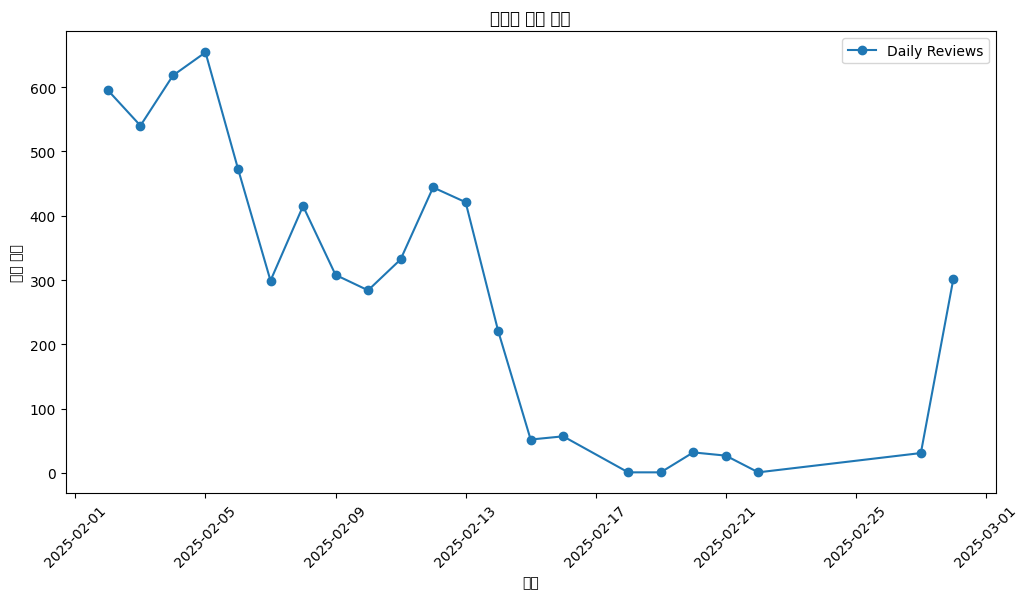

In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

# MySQL 연결 설정
db_config = {
    "host": "15.152.242.221",
    "port": 3306,
    "user": "admin",
    "password": "Admin@1234",
    "database": "musinsa_pd_rv"
}

# SQL 실행 (날짜별 리뷰 변화 데이터 가져오기)
query = """
SELECT 
    r.review_date,
    COUNT(*) AS daily_reviews,
    AVG(r.rating) AS avg_rating,
    SUM(CASE WHEN ra.sentiment = 2 THEN 1 ELSE 0 END) AS positive_count,
    SUM(CASE WHEN ra.sentiment = 1 THEN 1 ELSE 0 END) AS neutral_count,
    SUM(CASE WHEN ra.sentiment = 0 THEN 1 ELSE 0 END) AS negative_count,
    ROUND(SUM(CASE WHEN ra.sentiment = 0 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS negative_ratio
FROM reviews r
LEFT JOIN review_analysis ra ON r.review_id = ra.review_id
WHERE r.review_date >= DATE_SUB(NOW(), INTERVAL 30 DAY)
GROUP BY r.review_date
ORDER BY r.review_date;
"""

# MySQL에서 데이터 가져오기
conn = pymysql.connect(**db_config)
df = pd.read_sql(query, conn)
conn.close()

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(df["review_date"], df["daily_reviews"], marker="o", label="Daily Reviews")
plt.xlabel("날짜")
plt.ylabel("리뷰 개수")
plt.title("날짜별 리뷰 변화")
plt.legend()
plt.xticks(rotation=45)
plt.show()
